# This is a Project about skin cancer detection using AI

## First we import all the libraries we will be using

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
import time
import itertools


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import train_test_split
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



### We will be loading our dataset which contain about 10,000 images from ISIC(HAM10000)

In [2]:
# Define BASE_DIR and derived paths
BASE_DIR = r"E:\afeka\finalProject"
MEDIA_ROOT = os.path.join(BASE_DIR, 'JupyterLab')
ISIC_DIR = os.path.join(MEDIA_ROOT, 'ISIC-images')

metadata_path = os.path.join(ISIC_DIR, 'metadata.csv')
root_dir = ISIC_DIR  

# Load metadata
metadata = pd.read_csv(metadata_path)

# Fix image filenames (append .jpg)
metadata["image_name"] = metadata["isic_id"] + ".jpg"

# Check if images exist
missing_files = [f for f in metadata["image_name"] if not os.path.exists(os.path.join(root_dir, f))]

if missing_files:
    print("Missing files:", missing_files[:5]) 
else:
    print("All images exist.")


All images exist.


In [3]:
print(metadata.head())

        isic_id                                        attribution  \
0  ISIC_0024306  ViDIR Group, Department of Dermatology, Medica...   
1  ISIC_0024307  ViDIR Group, Department of Dermatology, Medica...   
2  ISIC_0024308  ViDIR Group, Department of Dermatology, Medica...   
3  ISIC_0024309  ViDIR Group, Department of Dermatology, Medica...   
4  ISIC_0024310  ViDIR Group, Department of Dermatology, Medica...   

  copyright_license  age_approx anatom_site_general anatom_site_special  \
0          CC-BY-NC        45.0                 NaN                 NaN   
1          CC-BY-NC        50.0     lower extremity                 NaN   
2          CC-BY-NC        55.0                 NaN                 NaN   
3          CC-BY-NC        40.0                 NaN                 NaN   
4          CC-BY-NC        60.0      anterior torso                 NaN   

  benign_malignant  concomitant_biopsy diagnosis diagnosis_1  \
0           benign               False     nevus      Benign   


### now we will print all the labels and the count for the label "diagnosis"

In [4]:
print(metadata.columns.tolist())  # List all column names
print(metadata["diagnosis"].value_counts())  # Check label distribution

['isic_id', 'attribution', 'copyright_license', 'age_approx', 'anatom_site_general', 'anatom_site_special', 'benign_malignant', 'concomitant_biopsy', 'diagnosis', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_confirm_type', 'image_type', 'lesion_id', 'melanocytic', 'sex', 'image_name']
diagnosis
nevus                         7737
pigmented benign keratosis    1338
melanoma                      1305
basal cell carcinoma           622
squamous cell carcinoma        229
vascular lesion                180
dermatofibroma                 160
actinic keratosis              149
Name: count, dtype: int64


### Visualize how common each skin condition is in the dataset using a horizontal bar chart and pie chart

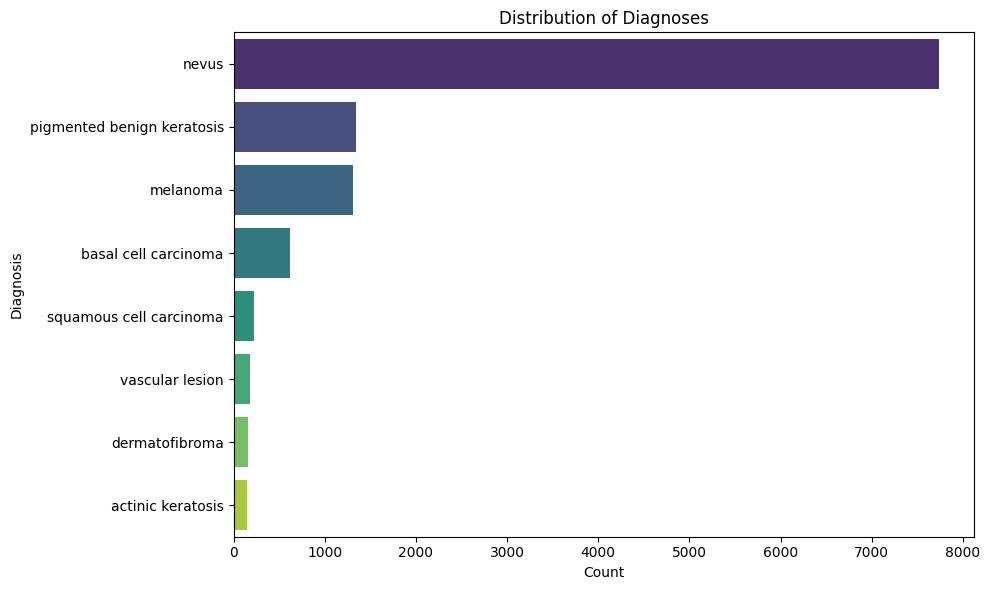

In [5]:
# Count diagnoses
diagnosis_counts = metadata['diagnosis'].value_counts().reset_index()
diagnosis_counts.columns = ['diagnosis', 'count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=diagnosis_counts,
    x='count',
    y='diagnosis',
    hue='diagnosis',  # This applies the palette per category
    dodge=False,
    palette="viridis",
    legend=False
)
plt.title("Distribution of Diagnoses")
plt.xlabel("Count")
plt.ylabel("Diagnosis")
plt.tight_layout()
plt.show()

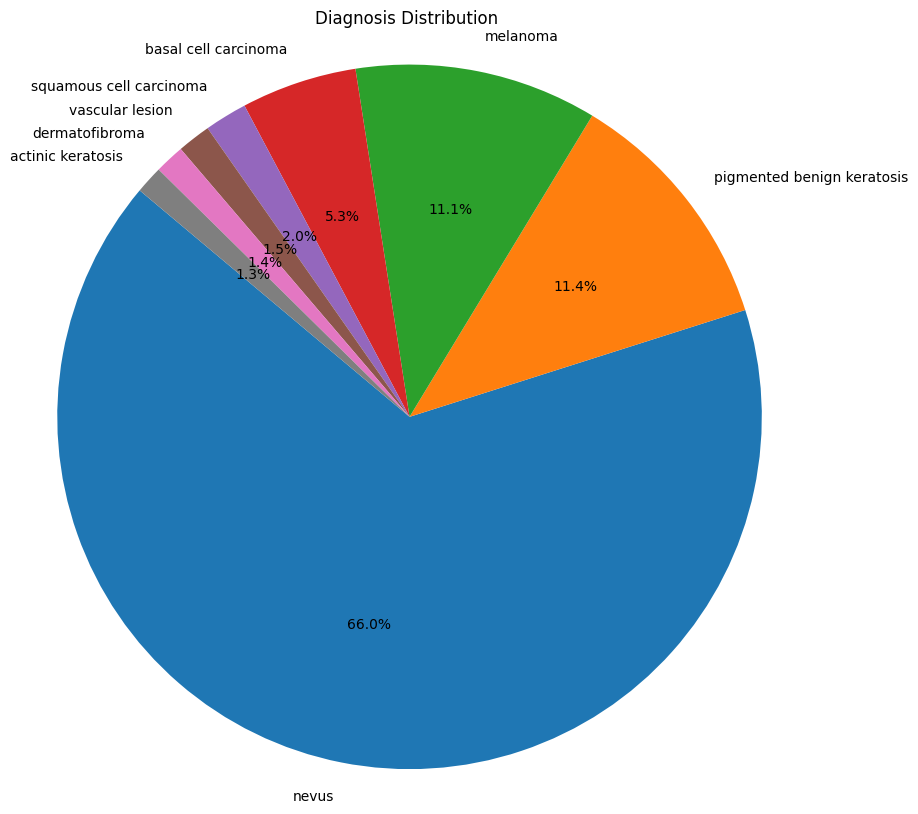

In [6]:
# Get all diagnosis counts
diagnosis_counts = metadata['diagnosis'].value_counts()

# Plot
plt.figure(figsize=(10, 10))
plt.pie(
    diagnosis_counts.values,
    labels=diagnosis_counts.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Diagnosis Distribution ")
plt.axis('equal')
plt.show()

### Mapping Lesions to Numeric Labels

In [7]:
# Identify the rows where 'diagnosis_1' is 'Indeterminate'
rows_to_drop = metadata[metadata['diagnosis_1'] == 'Indeterminate'].index

# Drop the rows from the dataframe
metadata.drop(rows_to_drop, inplace=True)

#reset the index
metadata.reset_index(drop=True, inplace=True)

In [8]:
# Define the label mapping function
def map_labels(row):
    # Nevus mapping
    if row["diagnosis"] == "nevus":
        return 0  # benign skin lesion
    
    # Melanoma mapping
    elif row["diagnosis"] == "melanoma":
        return 1  # Melanoma
    
    # If diagnosis is from other specific types and diagnosis_1 is Benign, classify as Nevus
    elif (row["diagnosis"] in ["pigmented benign keratosis", "basal cell carcinoma", "squamous cell carcinoma", 
                               "vascular lesion", "dermatofibroma", "actinic keratosis"]) and row["diagnosis_1"] == "Benign":
        return 0  # benign skin lesion
    
    # For Other lesion (Malignant)
    elif row["diagnosis"] == "Other lesion":
        if row["diagnosis_1"] in ["Malignant"]:
            return 1  # malignant skin lesion
    
    # If diagnosis is one of the other types and diagnosis_1 is Malignant, classify as Other lesion
    if row["diagnosis_1"] in ["Malignant"]:
        return 1  # malignant skin lesion

    return 1  # Default to Other lesion for any other case

# Apply the mapping function to create a new column 'mapped_label'
metadata["mapped_label"] = metadata.apply(map_labels, axis=1)

# Print class distribution
class_distribution = metadata["mapped_label"].value_counts().sort_index()
class_labels = {
    0: "Benign skin lesion",
    1: "Malignant skin lesion",
}

# Output the class distribution
print("Class Distribution:")
for label, count in class_distribution.items():
    print(f"{class_labels[label]}: {count}")


Class Distribution:
Benign skin lesion: 9415
Malignant skin lesion: 2156


### Visualizing the Distribution of Lesion Types

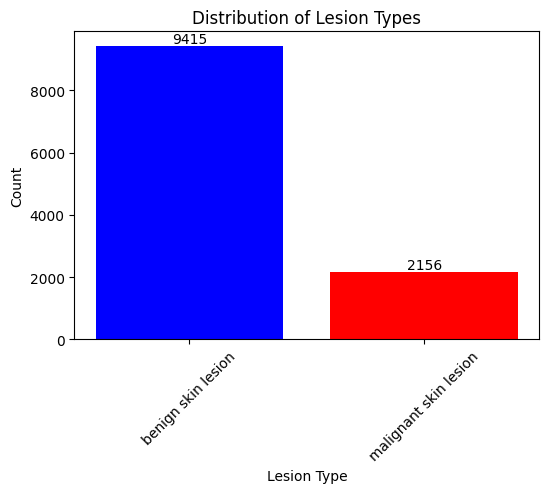

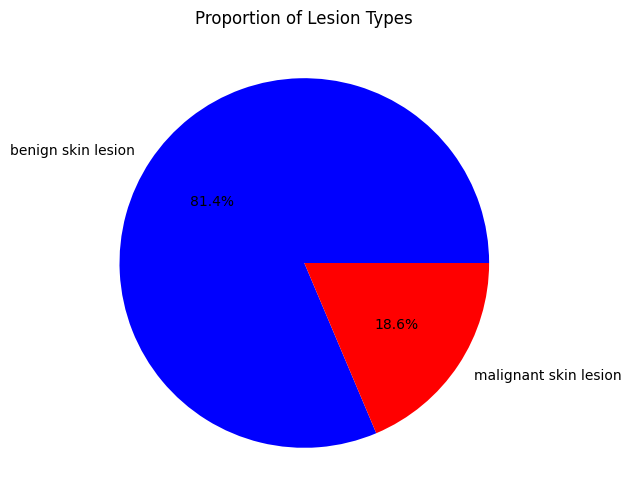

In [9]:
# Define the label mapping
label_mapping = {0: "benign skin lesion", 1: "malignant skin lesion"}

# Map the numeric labels to the string labels for better visualization
mapped_label_counts = metadata["mapped_label"].map(label_mapping).value_counts()

# Create the bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(mapped_label_counts.index, mapped_label_counts.values, color=['blue',  'red'])

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel("Lesion Type")
plt.ylabel("Count")
plt.title("Distribution of Lesion Types")
plt.xticks(ticks=range(len(mapped_label_counts.index)), labels=mapped_label_counts.index, rotation=45)
plt.show()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(mapped_label_counts.values, labels=mapped_label_counts.index, autopct='%1.1f%%', colors=['blue', 'red'])
plt.title("Proportion of Lesion Types")
plt.show()

### Data Preprocessing: Removing Unnecessary Columns and Handling Missing Values

In [10]:
columns_to_remove = ['attribution', 'copyright_license', 'image_type']  
metadata = metadata.drop(columns=columns_to_remove)  

# Display the first few rows to confirm
print(metadata.head())

        isic_id  age_approx anatom_site_general anatom_site_special  \
0  ISIC_0024306        45.0                 NaN                 NaN   
1  ISIC_0024307        50.0     lower extremity                 NaN   
2  ISIC_0024308        55.0                 NaN                 NaN   
3  ISIC_0024309        40.0                 NaN                 NaN   
4  ISIC_0024310        60.0      anterior torso                 NaN   

  benign_malignant  concomitant_biopsy diagnosis diagnosis_1  \
0           benign               False     nevus      Benign   
1           benign               False     nevus      Benign   
2           benign               False     nevus      Benign   
3           benign               False     nevus      Benign   
4        malignant                True  melanoma   Malignant   

                                       diagnosis_2    diagnosis_3  \
0                Benign melanocytic proliferations          Nevus   
1                Benign melanocytic proliferations

In [11]:
# Check if any missing values remain
print(metadata.isnull().sum())

isic_id                       0
age_approx                  380
anatom_site_general        2158
anatom_site_special       11040
benign_malignant           2529
concomitant_biopsy            0
diagnosis                     0
diagnosis_1                   0
diagnosis_2                   0
diagnosis_3                 180
diagnosis_confirm_type        0
lesion_id                     0
melanocytic                   0
sex                         340
image_name                    0
mapped_label                  0
dtype: int64


In [12]:
# Fill missing values in categorical columns with 'Unknown'
metadata['anatom_site_general'] = metadata['anatom_site_general'].fillna('Unknown')
metadata['anatom_site_special'] = metadata['anatom_site_special'].fillna('Unknown')
metadata['benign_malignant'] = metadata['benign_malignant'].fillna('Unknown')


# Fill missing values in numerical columns like 'age_approx' with the median
metadata['age_approx'] = metadata['age_approx'].fillna(metadata['age_approx'].median())

# Fill missing values in categorical columns with 'Unknown' or the mode
metadata['diagnosis_3'] = metadata['diagnosis_3'].fillna('Unknown')
metadata['sex'] = metadata['sex'].fillna(metadata['sex'].mode()[0])

In [13]:
print(metadata.isnull().sum())  # Check if any columns still have missing values

isic_id                   0
age_approx                0
anatom_site_general       0
anatom_site_special       0
benign_malignant          0
concomitant_biopsy        0
diagnosis                 0
diagnosis_1               0
diagnosis_2               0
diagnosis_3               0
diagnosis_confirm_type    0
lesion_id                 0
melanocytic               0
sex                       0
image_name                0
mapped_label              0
dtype: int64


In [14]:
print(metadata.head())  # Check the first few rows of the DataFrame

        isic_id  age_approx anatom_site_general anatom_site_special  \
0  ISIC_0024306        45.0             Unknown             Unknown   
1  ISIC_0024307        50.0     lower extremity             Unknown   
2  ISIC_0024308        55.0             Unknown             Unknown   
3  ISIC_0024309        40.0             Unknown             Unknown   
4  ISIC_0024310        60.0      anterior torso             Unknown   

  benign_malignant  concomitant_biopsy diagnosis diagnosis_1  \
0           benign               False     nevus      Benign   
1           benign               False     nevus      Benign   
2           benign               False     nevus      Benign   
3           benign               False     nevus      Benign   
4        malignant                True  melanoma   Malignant   

                                       diagnosis_2    diagnosis_3  \
0                Benign melanocytic proliferations          Nevus   
1                Benign melanocytic proliferations

In [15]:
label_encoder = LabelEncoder()
metadata['sex'] = label_encoder.fit_transform(metadata['sex'])

### CustomImageDataset: A PyTorch Dataset for Loading and Transforming Images

In [16]:
class CustomImageDataset(Dataset):
    def __init__(self, metadata_df, root_dir, transform=None):
        """
        Args:
            metadata_df (DataFrame): DataFrame containing image metadata.
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.metadata = metadata_df  # The DataFrame containing metadata
        self.metadata["mapped_label"] = self.metadata.apply(map_labels, axis=1)  # Map diagnosis to numeric labels (axis=1 applies to rows)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get image name 
        img_name = self.metadata.iloc[idx, 0] + ".jpg"  # Assuming the first column has image names without extension
        img_path = os.path.join(self.root_dir, img_name)  # Get full image path

        # Check if the file exists (optional but good practice)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image {img_name} not found in {self.root_dir}")

        # Load the image
        image = Image.open(img_path).convert("RGB")  # Open and convert to RGB if not already

        # Get the corresponding label (mapped label from the DataFrame)
        label = self.metadata.iloc[idx]["mapped_label"]

        # Apply transformations if provided (e.g., resize, normalize, etc.)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return the image and its label


### run the model on the device CPU/GPU

In [17]:
metadata.to_excel("metadata_output.xlsx", index=False)
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
NVIDIA GeForce RTX 4080 SUPER


### Setting Up ResNet-50 with Class Weights and Optimization 

In [18]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
class_weights = compute_class_weight(
    class_weight="balanced",  # Automatically balance class weights
    classes=np.array([0, 1]),  # Specify class labels explicitly
    y=metadata["mapped_label"].values  # Convert the 'mapped_label' column to a numpy array
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Loss function for multi-class classification

# Load ResNet-50 model with updated weights parameter
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

set_parameter_requires_grad(model, feature_extracting=False)

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # Fully connected layer with 512 units
    nn.ReLU(),                 # Apply ReLU activation
    nn.Dropout(0.5),           # Apply 50% dropout
    nn.Linear(512, 2)          # Final output layer with 2 classes ('benign skin lesion', 'malignant skin lesion')
)

# Initialize optimizer

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

# Adam optimizer can be used instead If needed:
optimizer = Adam(
    model.parameters(),
    lr=0.0001,
    betas=(0.9, 0.999),
    eps=1e-7,
    amsgrad=False
)


Class Weights: tensor([0.6145, 2.6834], device='cuda:0')


In [20]:
# Split the data into training and validation sets (80% training, 20% validation)
train_metadata, val_metadata = train_test_split(metadata, test_size=0.2, random_state=42)

# Check the split sizes
print(f"Training set size: {len(train_metadata)}")
print(f"Validation set size: {len(val_metadata)}")

Training set size: 9256
Validation set size: 2315


In [21]:
# Define transformations (data augmentation)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip 50% of images horizontally
    transforms.RandomRotation(degrees=15),   # Rotate images randomly by ±15 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop + resize
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),  # Randomly zoom image, scale range between 90% to 110%
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean/std
 ])

val_transform = transforms.Compose([
    transforms.Resize(256),                # Resize the shorter side to 256
    transforms.CenterCrop(224),           # Then take a center crop of size 224×224
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(                 # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Initialize the CustomImageDataset with the DataFrame
train_dataset = CustomImageDataset(metadata_df=train_metadata, root_dir=root_dir, transform=transform)
val_dataset = CustomImageDataset(metadata_df=val_metadata, root_dir=root_dir, transform=val_transform)

# Set up the DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Test if the dataloader works
for images, labels in train_loader:
    print(f"Batch of images: {images.shape}, Labels: {labels.shape}")
    break
for images, labels in val_loader:
    print(f"Validation batch: {images.shape}, Labels: {labels.shape}")
    break


Batch of images: torch.Size([16, 3, 224, 224]), Labels: torch.Size([16])
Validation batch: torch.Size([16, 3, 224, 224]), Labels: torch.Size([16])


In [22]:
# Function to apply Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        # Hook to get gradients
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, class_idx):
        grad_val = self.gradients.cpu().data.numpy()
        act_val = self.activation.cpu().data.numpy()

        weights = np.mean(grad_val, axis=(2, 3), keepdims=True)
        cam = np.sum(weights * act_val, axis=1)

        # Normalize and resize CAM
        cam = np.maximum(cam, 0)  # ReLU
        cam = cam[0]  # Get first item
        cam = cv2.resize(cam, (224, 224))  # Resize to match image

        # Normalize CAM
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

### Training the Model with Early Stopping and Validation

In [23]:
# Define a function for the training loop
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, clip_grad_norm=None):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    start_time = time.time()  # Track epoch time
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping (if applicable)
        if clip_grad_norm:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Log learning rate every 100 iterations 
        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Iteration {i + 1}/{len(train_loader)}")


    # Calculate average loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_predictions / total_predictions
    
    # Print epoch time
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")

    return train_loss, train_accuracy

# Define a function for the validation loop
def validate_model(model, val_loader, criterion, device, num_examples=5):
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    # Store misclassified images, true labels, and predicted labels
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)

            # Find misclassified images
            misclassified_mask = predicted != labels
            misclassified_images.extend(inputs[misclassified_mask].cpu())
            true_labels.extend(labels[misclassified_mask].cpu())
            predicted_labels.extend(predicted[misclassified_mask].cpu())

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions

    return val_loss, val_accuracy, misclassified_images, true_labels, predicted_labels



In [24]:
# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Set early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
best_Accuracy = float('inf')
epochs_without_improvement = 0

num_epochs = 20  # Set the number of epochs
# Set up device
model.to(device)

# Store misclassified images at the end
final_misclassified_images = []
final_true_labels = []
final_predicted_labels = []

# Training and validation loop
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    val_loss, val_accuracy, misclassified_images, true_labels, predicted_labels = validate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save the last batch of misclassified images
    final_misclassified_images = misclassified_images
    final_true_labels = true_labels
    final_predicted_labels = predicted_labels

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_accuracy = val_accuracy
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'resnet50_skin_lesion_classification.pth')
        torch.save(optimizer.state_dict(), 'resnet50_skin_lesion_optimizer.pth')
        print("Best Model saved")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered!")
            break

# Print final results
print(f"Finished Training and Validation, Best Model Accuracy: {best_accuracy:.2f}%, Loss: {best_val_loss:.4f}")

Epoch 1, Iteration 100/579
Epoch 1, Iteration 200/579
Epoch 1, Iteration 300/579
Epoch 1, Iteration 400/579
Epoch 1, Iteration 500/579
Epoch 1 completed in 75.05 seconds
Epoch [1/20], Loss: 0.4766, Accuracy: 75.85%
Validation Loss: 0.3998, Validation Accuracy: 80.56%
Best Model saved
Epoch 2, Iteration 100/579
Epoch 2, Iteration 200/579
Epoch 2, Iteration 300/579
Epoch 2, Iteration 400/579
Epoch 2, Iteration 500/579
Epoch 2 completed in 72.24 seconds
Epoch [2/20], Loss: 0.4111, Accuracy: 81.66%
Validation Loss: 0.3688, Validation Accuracy: 82.63%
Best Model saved
Epoch 3, Iteration 100/579
Epoch 3, Iteration 200/579
Epoch 3, Iteration 300/579
Epoch 3, Iteration 400/579
Epoch 3, Iteration 500/579
Epoch 3 completed in 72.78 seconds
Epoch [3/20], Loss: 0.3672, Accuracy: 83.49%
Validation Loss: 0.3560, Validation Accuracy: 84.79%
Best Model saved
Epoch 4, Iteration 100/579
Epoch 4, Iteration 200/579
Epoch 4, Iteration 300/579
Epoch 4, Iteration 400/579
Epoch 4, Iteration 500/579
Epoch 4 co

### Visualizing Model Performance: Loss & Accuracy Trends

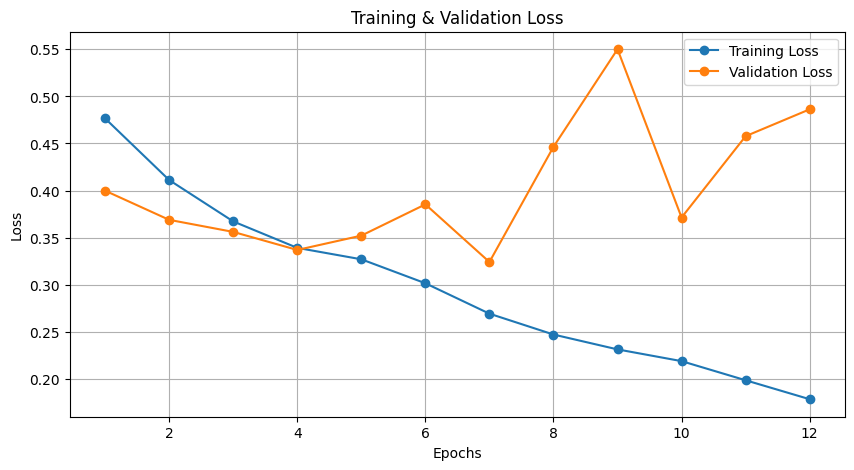

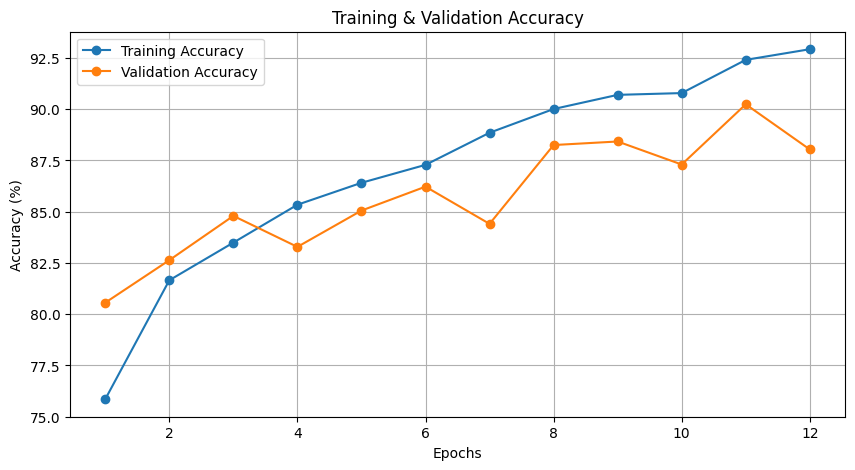

In [25]:
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

### Confusion Matrix and Misclassified Images Analysis

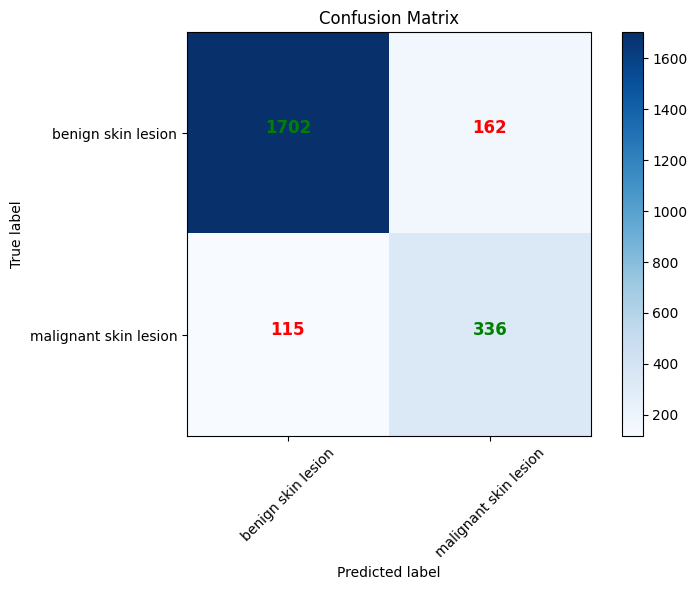

Showing 5 misclassified images from final validation:


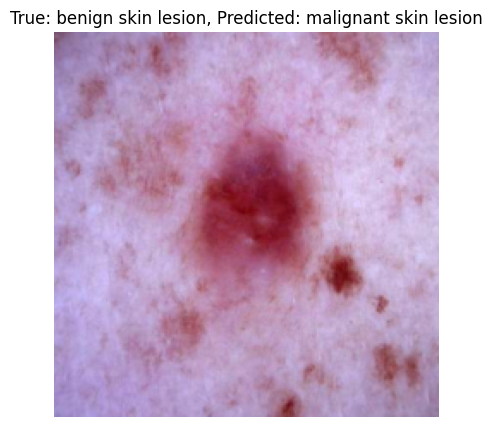

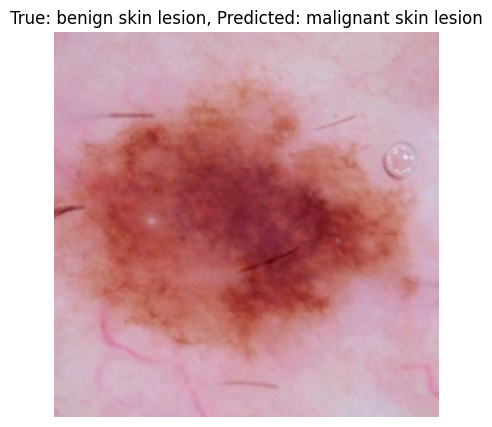

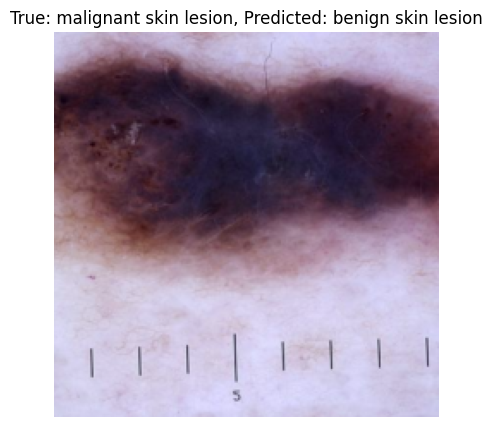

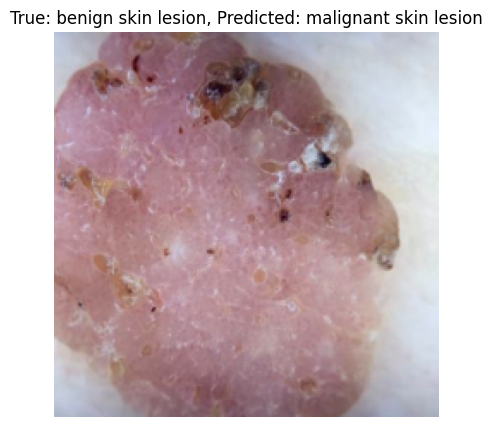

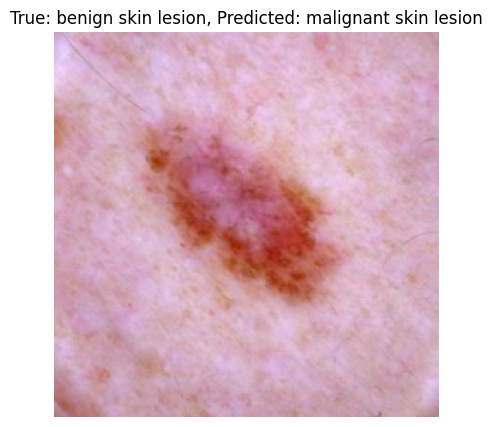

In [28]:
# Define a mapping for label names
label_mapping = {0: "benign skin lesion", 1: "malignant skin lesion"}
# Set threshold
threshold = 0.7

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predictions = outputs.max(1)[1]  # Get predicted class index

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Compute confusion matrix 
confusion_mtx = confusion_matrix(y_true, y_pred)

# Function to plot confusion matrix with COUNT values
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row sum

    # Define threshold for color contrast
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "green" if i == j else "red"  # Green for correct, Red for incorrect
        plt.text(j, i, f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]}",
                 horizontalalignment="center",
                 color=color, fontsize=12, fontweight="bold")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

# Plot confusion matrix as COUNT instead of percentage
plot_confusion_matrix(confusion_mtx, list(label_mapping.values()), normalize=False, title="Confusion Matrix")


if len(final_misclassified_images) > 0:
    print(f"Showing {min(5, len(final_misclassified_images))} misclassified images from final validation:")
    for i in range(min(5, len(final_misclassified_images))):
        image = final_misclassified_images[i]
        true_label = label_mapping[final_true_labels[i].item()]
        predicted_label = label_mapping[final_predicted_labels[i].item()]

        # Convert tensor to numpy and denormalize
        image = image.permute(1, 2, 0).numpy() 
        if image.min() < 0 or image.max() > 1: 
            image = (image - image.min()) / (image.max() - image.min())

        # Plot the image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis("off")
        plt.show()

## Compute and print classification metrics


In [29]:
# Compute and print classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8803
Precision: 0.6747
Recall: 0.7450
F1 Score: 0.7081


**Model Performance Summary**

We achieved an **88.03% prediction accuracy**, with a **Precision of 67.47%**, **Recall of 74.50%**, and **F1 Score of 70.81%** on the validation set.  
These results indicate that the model is reasonably effective at distinguishing between benign and malignant skin lesions, though there is room for improvement in precision.  

### Grad-CAM Visualization for Model Predictions

In [ ]:
# Path to the directory containing images
image_dir = os.path.join(MEDIA_ROOT, 'images_ToTest', 'images')

# Get all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Set model to evaluation mode
model.eval()

# Define confidence threshold (adjust as needed)
confidence_threshold = 70  # Threshold in percentage 

# Class labels
class_labels = ['benign skin lesion', 'malignant skin lesions']

# Choose the layer for ResNet (last conv layer in layer4)
target_layer = model.layer4[-1] 

# Initialize Grad-CAM
grad_cam = GradCAM(model=model, target_layer=target_layer)

# Iterate through all images
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    
    # Load and preprocess the image
    image = Image.open(image_path)
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    input_tensor.requires_grad_(True)  # Enable gradient computation

    # Forward pass
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)  # Get softmax probabilities
    confidence, predicted = torch.max(probabilities, 1)  # Get max probability and index

    # Perform backward pass to compute gradients
    model.zero_grad()  # Clear existing gradients
    output[0, predicted.item()].backward()  # Backward pass for the predicted class

    predicted_class = class_labels[predicted.item()]
    confidence_percentage = confidence.item() * 100  # Convert to percentage

    # Extract image ID from filename 
    image_id = os.path.splitext(image_file)[0]  

    # Generate the Grad-CAM heatmap
    cam = grad_cam.generate_cam(predicted.item())  # Pass the predicted class index

    # Convert original image to NumPy array
    image_np = np.array(image.resize((224, 224)))

    # Squeeze the CAM to ensure it's 2D
    cam = np.squeeze(cam)

    # Normalize and convert cam to uint8
    cam = cam - np.min(cam)  # Shift values to positive range
    cam = cam / np.max(cam)  # Normalize to [0,1]
    cam = np.uint8(255 * cam)  # Scale to [0,255] and convert to uint8

    # Overlay heatmap on image
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # Print results with percentage confidence and display Grad-CAM
    if confidence_percentage < confidence_threshold:
        print(f"Image ID: {image_id}, Prediction Uncertain (Confidence: {confidence_percentage:.2f}%)")
    else:
        print(f"Image ID: {image_id}, Predicted Outcome: {predicted_class} (Confidence: {confidence_percentage:.2f}%)")

    # Display the original and Grad-CAM result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title(f"Original Image: {image_id}")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Heatmap")
    

    plt.show()

In [32]:
# Path to OOD images
ood_folder = r"E:\afeka\finalProject\JupyterLab\ISIC-images\OOD_test_images"

# Your label mapping
label_mapping = {0: "benign skin lesion", 1: "malignant skin lesion"}

# Set threshold
threshold = 0.80

# Set model to eval mode
model.eval()

# Process each OOD image
for filename in os.listdir(ood_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(ood_folder, filename)
        print(f"\nProcessing image: {filename}")
        
        # Load and preprocess image
        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)
        
        # Model inference
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, pred_class = probs.max(1)
            
            confidence = confidence.item()
            pred_class = pred_class.item()
            
            # Decision
            if confidence < threshold:
                print(f"Prediction: UNKNOWN (Confidence: {confidence:.2f})")
            else:
                print(f"Prediction: {label_mapping[pred_class]} (Confidence: {confidence:.2f})")



Processing image: animal_image1.jpg
Prediction: malignant skin lesion (Confidence: 0.87)

Processing image: animal_image2.jpg
Prediction: malignant skin lesion (Confidence: 0.94)

Processing image: animal_image3.jpg
Prediction: UNKNOWN (Confidence: 0.78)

Processing image: animal_image4.jpg
Prediction: benign skin lesion (Confidence: 1.00)

Processing image: animal_image5.jpg
Prediction: benign skin lesion (Confidence: 0.98)

Processing image: car_image1.jpg
Prediction: benign skin lesion (Confidence: 1.00)

Processing image: car_image2.jpg
Prediction: UNKNOWN (Confidence: 0.56)

Processing image: car_image3.jpg
Prediction: benign skin lesion (Confidence: 1.00)

Processing image: car_image4.jpg
Prediction: benign skin lesion (Confidence: 0.98)

Processing image: car_image5.jpg
Prediction: benign skin lesion (Confidence: 1.00)

Processing image: nature_image1.jpg
Prediction: benign skin lesion (Confidence: 0.95)

Processing image: nature_image2.jpg
Prediction: benign skin lesion (Confi

**OOD Testing**

We added a set of Out-of-Distribution (OOD) images (cars, animals, nature, and people) to the test set to evaluate how well the model handles unrelated images.  
A confidence threshold of 80% was used — predictions below this are classified as "UNKNOWN."  
Results showed that raising the threshold improved the model's ability to reject OOD images, but some confident misclassifications still occurred.
